In [1]:
library(tidyverse)
library(stringr)
library(lubridate)
#install.packages("ggmap")
library(ggmap)
#install.packages("dbscan")
library(dbscan)
#install.packages("ggpubr")
library(ggpubr)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'ggmap' was built under R version 4.0.3"
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Warning message:
"package 'dbscan' was built under R version 4.0.3"
Warning message:
"package 'ggpubr' was built under R version 4.0.3"


# Where are the most accident-prone areas of Chicago?

## Methodology
In exploring this question, we will take a spatial approach to answering it. Rather than organizing tibbles of street names and sorting them by street number, we will consider two types of crashes, (1) all accidents and (2) accidents where people were incapacitated or fatally injured, and:
1. Plot the two types of accidents on the map of Chicago, where each accident is represented by a point.
2. Plot density estimates of both types of accidents on the maps of Chicago and downtown Chicago.
3. Perform cluster analysis on incapacitated/fatal accidents with the DBSCAN algorithm, aggressively filtering out noise, to find hotspots.

We filter our accidents according to latitude and longitude bounds to remove `NA` entries and entries where either latitude and longitude were equal to zero.

In [111]:
### BEGIN SOLUTION
traffic <- read_csv("chicagotraffic2019.csv")

traffic = traffic %>% filter(!is.na(LATITUDE), !is.na(LONGITUDE), 
                             LATITUDE>0, LONGITUDE<0)
traffic_injuries = traffic %>% filter((INJURIES_FATAL+INJURIES_INCAPACITATING) > 0, !is.na(INJURIES_FATAL))
traffic %>% head

downtown_traffic = traffic %>% filter(LATITUDE > 41.86, LATITUDE < 41.918, 
                                    LONGITUDE > -87.66, LONGITUDE < -87.606)
downtown_injuries = traffic_injuries %>% filter(LATITUDE > 41.86, LATITUDE < 41.918, 
                                    LONGITUDE > -87.66, LONGITUDE < -87.606)

print(c(left = min(traffic$LONGITUDE, na.rm=TRUE), 
                                  bottom = min(traffic$LATITUDE, na.rm=TRUE), 
                                  right = max(traffic$LONGITUDE, na.rm=TRUE), 
                                  top = max(traffic$LATITUDE, na.rm=TRUE)))

Warning message:
"Missing column names filled in: 'X1' [1]"
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  POSTED_SPEED_LIMIT = col_double(),
  LANE_CNT = col_double(),
  STREET_NO = col_double(),
  BEAT_OF_OCCURRENCE = col_double(),
  NUM_UNITS = col_double(),
  INJURIES_TOTAL = col_double(),
  INJURIES_FATAL = col_double(),
  INJURIES_INCAPACITATING = col_double(),
  INJURIES_NON_INCAPACITATING = col_double(),
  INJURIES_REPORTED_NOT_EVIDENT = col_double(),
  INJURIES_NO_INDICATION = col_double(),
  INJURIES_UNKNOWN = col_double(),
  CRASH_HOUR = col_double(),
  CRASH_DAY_OF_WEEK = col_double(),
  CRASH_MONTH = col_double(),
  LATITUDE = col_double(),
  LONGITUDE = col_double()
)

See spec(...) for full column specifications.



X1,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5,00e47f189660cd8ba1e85fc63061bf1d8465184393f134fb8251ed7896a4ba9ed7c984ab51a01f564d6f4133c6ef8493b1a369743a4a308d4392900a286e160f,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,...,0,0,2,0,22,5,3,41.74180,-87.74095,POINT (-87.740953581987 41.741803598989)
8,0211e1f766f3940dfa87375661d25b716655e908c320cc46910e8fa5fb1f1e6a9d4f714d21e8e401ec9e0a12190b6cd9f6dbc97d32d0c0fc966a02ae516e782f,JC301403,06/11/2019 08:40:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0,0,3,0,8,3,6,41.79478,-87.62383,POINT (-87.623828038036 41.794778764028)
15,046c0f96fdf5f7384e026821bb23fdd56d610dce11247b4cf7072f4e0308cdf5865ee8f31d71792ef005d864c064aae933213ef5e4e87a9bb2247ffe0f56f245,JC128226,01/24/2019 06:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,...,0,0,2,0,6,5,1,41.79478,-87.62383,POINT (-87.623828038036 41.794778764028)
17,0564e565ebda939c88d5da6d613ac5789b702cbff5b8744552f9930bd571995afb81a895dfd2bc8a23e6cca53f8fc6a9afbeb38591781281a3c37ceba5cbcbd5,JC541936,12/10/2019 03:15:00 PM,20,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,...,0,0,2,0,15,3,12,41.95420,-87.66919,POINT (-87.669192620028 41.954196228965)
20,06d11d0ac4bf97a43f93b78768b225c91ba0579939a4fc92ba3f426a1353607f52a8f8536eefb3a7a3e75f553d1e941841ce5b26890e986b06ad85a716fa3a2c,JC263263,05/14/2019 07:30:00 PM,20,PEDESTRIAN CROSSING SIGN,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,...,1,0,2,0,19,3,5,41.95068,-87.64378,POINT (-87.64378474303 41.950676838996)
23,074f50577888fe85727b97fe0010aa708efe985ae1effdd2d03730c444e95bf795e54e0f7a2123d3c97b8fc80e7b822ce64fdcef7dd6f1b510a0856c7d8d669f,JC539018,12/08/2019 08:14:00 AM,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,0,0,2,0,8,1,12,41.75872,-87.58559,POINT (-87.585590902031 41.758723759994)


     left    bottom     right       top 
-87.93401  41.64467 -87.52459  42.02272 


## Summary of Crash Counts
To get a better idea of the size of the dataset we are dealing with, we display, in the form of a table, a few important summary statistics about the amount of accidents we deal with, in each of the four categories we divide them into. We see that the proportion of accidents where people were injured/fatally injured is small (1.8%), and that when taking area into account, the proportion of accidents that occured in in downtown Chicago is very large (13.6%). We explore this further later on with density estimates.

In [112]:
crash_count = count(traffic)[['n']]
injury_count = count(traffic_injuries)[['n']]
downtown_count = (traffic %>% filter(LATITUDE > 41.86, LATITUDE < 41.918, 
                                    LONGITUDE > -87.66, LONGITUDE < -87.606) %>% count())[['n']]
downtown_injuries_count = (traffic_injuries %>% filter(LATITUDE > 41.86, LATITUDE < 41.918, 
                                    LONGITUDE > -87.66, LONGITUDE < -87.606) %>% count())[['n']]

tibble(Situations = c("Total Accidents", 
      "Total Injuries/Fatal Accidents",
      "Downtown Accidents",
      "Downtown Injuries/Fatal Accidents"), 
       Counts = c(crash_count,injury_count,downtown_count,downtown_injuries_count))

Situations,Counts
<chr>,<int>
Total Accidents,116820
Total Injuries/Fatal Accidents,2103
Downtown Accidents,15938
Downtown Injuries/Fatal Accidents,230


## Accident Density Estimates

Maps of Chicago are obtained from the open source maps available from `Stamen`, and the `ggmap` package based off `ggplot2` is used to visualize our data on top of these maps. We generate six maps

In [22]:
chicago <- get_stamenmap(bbox = c(left = -88, 
                                  bottom = 41.6, 
                                  right = -87.4, 
                                  top = 42.05), 
                         zoom = 11, maptype="watercolor")

c1 = ggmap(chicago) + geom_point(data=traffic, aes(x = LONGITUDE , y = LATITUDE), size=0.01, color="black") + 
ggtitle("All Accidents") + xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "none", axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold"))  

c2 = ggmap(chicago) + geom_point(data=traffic_injuries, aes(x = LONGITUDE , y = LATITUDE), size=0.01, color="blue") + 
ggtitle("Incapacitated/Fatal") + xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "none", axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) 

In [5]:
c3 = ggmap(chicago) + stat_density_2d_filled(data=traffic, aes(x = LONGITUDE , y = LATITUDE), alpha=0.8) +
  scale_fill_manual(values = c(NA, "#482677FF", "#404788FF", "#33638DFF",
                               "#2D708EFF", "#1F968BFF", 
                               "#29AF7FFF", "#3CBB75FF",  
                               "#95D840FF", "#B8DE29FF", "#DCE319FF", "#FDE725FF")) + 
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "none", axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) + 
ggtitle("All Accidents, Density")

c4 = ggmap(chicago) + stat_density_2d_filled(data=traffic_injuries, aes(x = LONGITUDE , y = LATITUDE), alpha=0.8) +
  scale_fill_manual(values = c(NA, NA, "#482677FF", "#33638DFF",
                               "#1F968BFF", 
                               "#29AF7FFF", 
                               "#95D840FF", "#DCE319FF", "#FDE725FF")) + 
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "none", axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) + 
ggtitle("Incapacited/Fatal, Density")



In [58]:
chicago_zoom <- get_stamenmap(bbox = c(left = -87.81, 
                                  bottom = 41.71, 
                                  right = -87.55, 
                                  top = 42.03), 
                         zoom = 12, maptype="watercolor")
c5 = ggmap(chicago_zoom) + stat_density_2d_filled(data=traffic, aes(x = LONGITUDE , y = LATITUDE), alpha=0.8) +
  scale_fill_manual(values = c(NA, NA, "#482677FF", "#404788FF", "#33638DFF",
                                "#287D8EFF", "#1F968BFF", 
                               "#29AF7FFF", "#3CBB75FF", "#55C667FF", 
                               "#95D840FF", "#DCE319FF", "#FDE725FF")) + 
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "right", legend.title = element_text(size=7), 
      legend.text = element_text(size=6), axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) + 
labs(fill = "Density Estimate") + ggtitle("All Accidents, Density")

c6 = ggmap(chicago_zoom) + stat_density_2d_filled(data=traffic_injuries, aes(x = LONGITUDE , y = LATITUDE), alpha=0.8) +
  scale_fill_manual(values = c(NA, NA, "#482677FF", "#404788FF", "#33638DFF",
                               "#1F968BFF", 
                               "#29AF7FFF", "#55C667FF", 
                               "#DCE319FF", "#FDE725FF")) + 
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "right", legend.title = element_text(size=7), 
      legend.text = element_text(size=6), axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) + 
labs(fill = "Density Estimate") + ggtitle("Incapacited/Fatal, Density")


In [113]:
chicago_center <- get_stamenmap(bbox = c(left = -87.66, 
                                  bottom = 41.86, 
                                  right = -87.606, 
                                  top = 41.918), 
                         zoom = 14, maptype="watercolor")
c7 = ggmap(chicago_center) + stat_density_2d_filled(data=downtown_traffic, aes(x = LONGITUDE , y = LATITUDE), alpha=0.85) +
  scale_fill_manual(values = c(NA, NA, "#482677FF", "#33638DFF",
                               "#29AF7FFF", "#55C667FF", 
                               "#95D840FF", "#FDE725FF")) + 
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "right", legend.title = element_text(size=7), 
      legend.text = element_text(size=6), axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) +
labs(fill = "Density Estimate") + ggtitle("All Accidents, Downtown")

c8 = ggmap(chicago_center) + stat_density_2d_filled(data=downtown_injuries, aes(x = LONGITUDE , y = LATITUDE), alpha=0.85) +
  scale_fill_manual(values = c(NA, NA, "#482677FF", "#33638DFF",
                              "#287D8EFF", "#1F968BFF", 
                               "#29AF7FFF",  "#55C667FF", 
                               "#95D840FF", "#B8DE29FF", "#DCE319FF", "#FDE725FF")) +
xlab("Longitude") + ylab("Latitude") + 
theme(legend.position = "right", legend.title = element_text(size=7), 
      legend.text = element_text(size=6), axis.text=element_text(size=7), 
      axis.title=element_text(size=10), plot.title=element_text(size=10,face="bold")) + 
labs(fill = "Density Estimate") + ggtitle("Incapacited/Fatal, Downtown")


In [8]:
options(jupyter.plot_scale=1)

Warning message:
"Removed 7239 rows containing non-finite values (stat_density2d_filled)."
Warning message:
"Removed 146 rows containing non-finite values (stat_density2d_filled)."


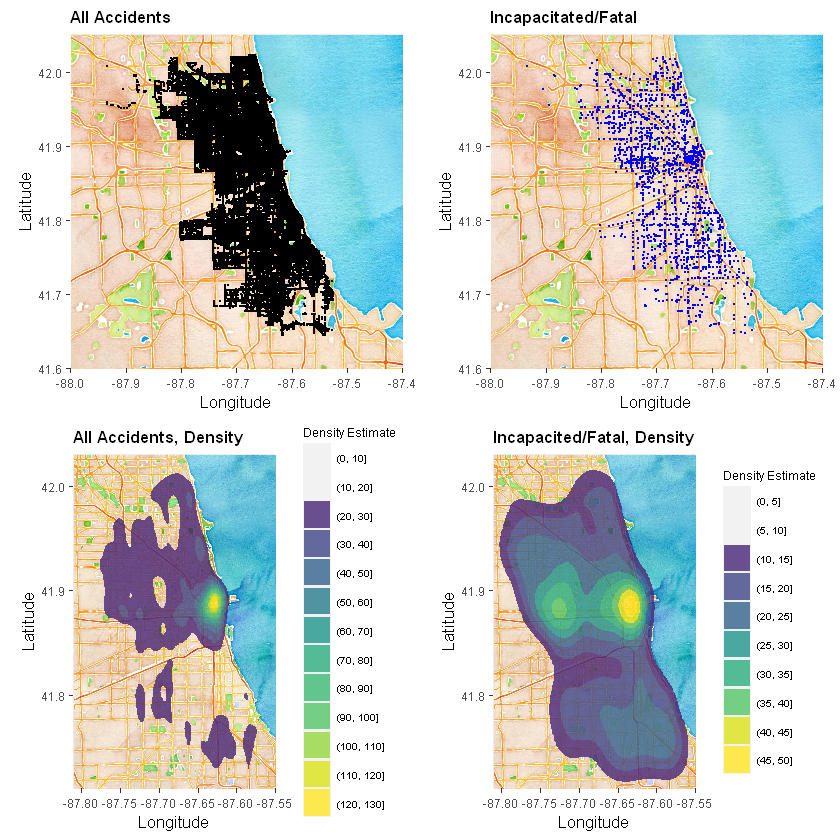

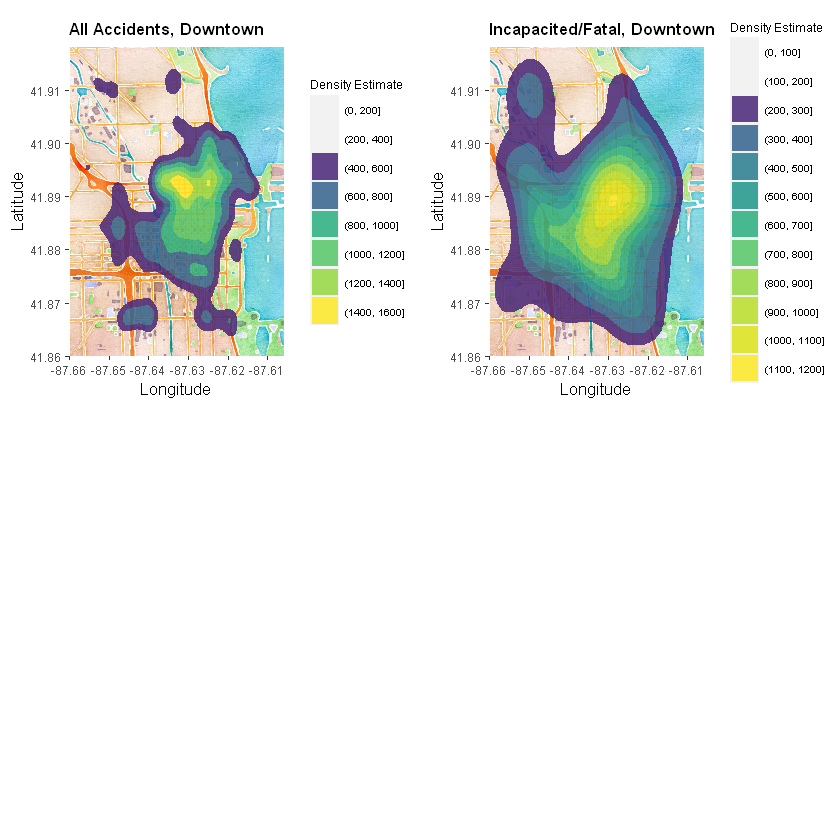

In [114]:
f1 = ggarrange(c1,c2,c5,c6, ncol=2, nrow=2)
f2 = ggarrange(c7,c8,ncol=2, nrow=2)
f1
f2

Warning message:
"Removed 370 rows containing missing values (geom_point)."
Warning message:
"Removed 65 rows containing missing values (geom_point)."


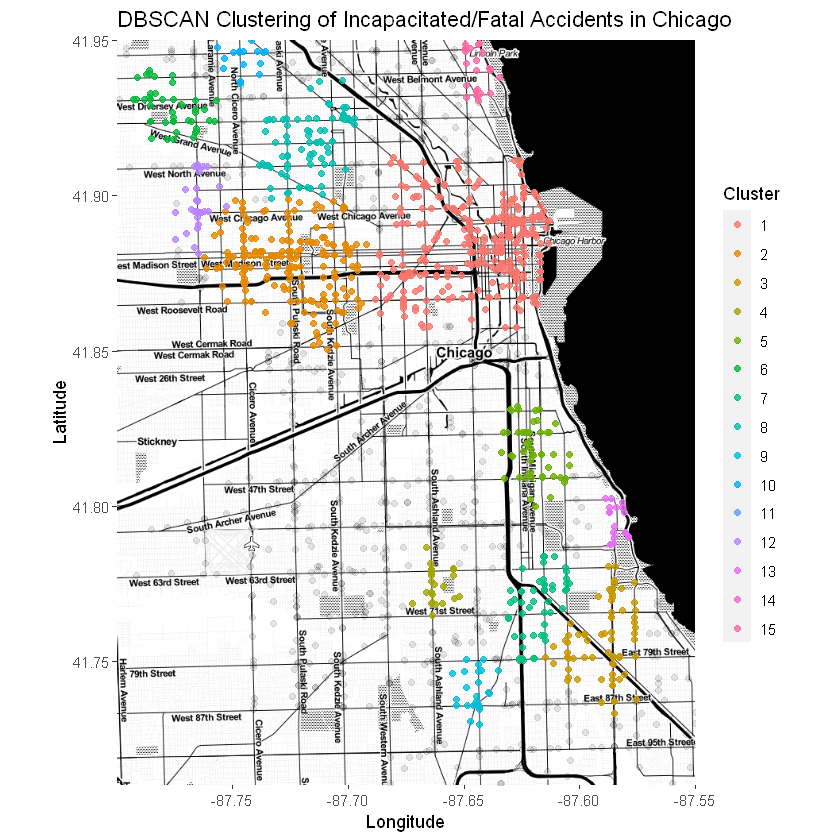

In [139]:
chicago_zoom_toner <- get_stamenmap(bbox = c(left = -87.8, 
                                  bottom = 41.71, 
                                  right = -87.55, 
                                  top = 41.95), 
                         zoom = 12, maptype="toner")

clusters = dbscan(traffic_injuries %>% select(LATITUDE, LONGITUDE), eps=0.01, minPts = 20)

traffic_injuries = traffic_injuries %>% mutate(cluster = clusters$cluster)
Cluster = as.factor((traffic_injuries %>% filter(cluster>0))$cluster)

ggmap(chicago_zoom_toner) + 
geom_point(data=traffic_injuries %>% filter(cluster==0), aes(x = LONGITUDE , y = LATITUDE), alpha=0.1) +
geom_point(data=traffic_injuries %>% filter(cluster>0), 
           aes(x = LONGITUDE , y = LATITUDE, color=Cluster), alpha=0.8) +
xlab("Longitude") + ylab("Latitude") + ggtitle("DBSCAN Clustering of Incapacitated/Fatal Accidents in Chicago")

In [98]:
lev = c('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15', "Noise")

as_tibble(clusters$cluster) %>% mutate(Cluster = factor(ifelse(value==0, "Noise", value),levels = lev)) %>% 
group_by(Cluster) %>% summarize(Count = n())

`summarise()` ungrouping output (override with `.groups` argument)



Cluster,Count
<fct>,<int>
1,322
2,193
3,79
4,25
5,50
6,46
7,53
8,79
9,25
